<a href="https://colab.research.google.com/github/digital-science/dimensions-api-lab/blob/master/2-sample-applications/Publications-for-European-Cities/Publications-distribution-for-European-Cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Dimensions API Lab In Google Colab"/></a>

# Comparing the publications volume of cities in Europe

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to measure the distribution of overall number of publications per European cities. For the purpose of this exercise, we will look at a specific year i.e. 2018.

This data will allow us to create a nice-looking map where cities producing more research can be identified visually.

> **Customize this notebook:** simply change the geographical area and time-span to adapt this analysis to your needs! 

#### Prerequisites

In [1]:
# data analysis libraries 
import time 
import pandas as pd 
import requests  
import json 
# Dimensions API query helper
import dimcli
dimcli.login()dsl = dimcli.Dsl()
# 

DimCli v0.4.3 - Succesfully connected to <https://app.dimensions.ai>


## 1. Getting the publications data from Dimensions

Dimensions DSL API can return a maximim of 1000 results per call, so in order to get the data we are interested in we need to break down the queries into smaller components. 

We can do so by creating a separate query for each EU country, for a full year, and extract all the cities information from it.

This is what this query would look like:

In [3]:
%%dsl_query
search publications
where type="article" and year="2018" and research_org_countries in ["GB"]
return research_org_cities limit 1000

Tot Publications:  208597
Returned Research_org_cities: 1000


<dimcli.Result object #4585020608: [('research_org_cities', 1000), ('_stats', 1)]>

In order to take a peek at the data let's put it into a pandas frame

In [4]:
data = _['research_org_cities']
df1 = pd.DataFrame.from_dict(data)
df1.head()

,count,id,name
0,63893,2643743,London
1,16173,2653941,Cambridge
2,16073,2640729,Oxford
3,10695,2643123,Manchester
4,10403,2650225,Edinburgh


In essence, we want to run the query above for all countries in the EU, then collate the data into a single table. 

First, let's define the list of countries we need (PS: country codes are based on geonames, see also https://www.geonames.org/countries/)

In [5]:
europe_countries = ["AD","AL","AT","AX","BA","BE","BG","BY","CH","CZ","DE","DK","EE","ES","FI","FO","FR","GB","GG","GI","GR","HR","HU","IE","IM","IS","IT","JE","LI","LT","LU","LV","MC","MD","ME","MK","MT","NL","NO","PL","PT","RO","RS","RU","SE","SI","SJ","SK","SM","UA","VA"]

Now we can set up a parametrized query loop as follows 

In [6]:
q_template = """search publications
where type="article" and date="2018" and research_org_countries in ["%s"]
return research_org_cities limit 1000"""

In [7]:
df_master = pd.DataFrame()
for c in europe_countries:
    query = q_template % (c)
    res = dsl.query(query, show_results=False)
    data = res['research_org_cities']
    if data:
        if df_master.empty:
            df_master = pd.DataFrame.from_dict(data)
        else:
            df_temp = pd.DataFrame.from_dict(data)
            df_master = df_master.append(df_temp, sort=True)
    print("Country:", c, " - Master Dataset Rows:", len(df_master))
    time.sleep(1.5)
print("FINISHED!")    

Country: AD Master Dataset Rows: 0 <class 'pandas.core.frame.DataFrame'>
Country: AL Master Dataset Rows: 6 <class 'pandas.core.frame.DataFrame'>
Country: AT Master Dataset Rows: 177 <class 'pandas.core.frame.DataFrame'>
Country: AX Master Dataset Rows: 177 <class 'pandas.core.frame.DataFrame'>
Country: BA Master Dataset Rows: 182 <class 'pandas.core.frame.DataFrame'>
Country: BE Master Dataset Rows: 482 <class 'pandas.core.frame.DataFrame'>
Country: BG Master Dataset Rows: 510 <class 'pandas.core.frame.DataFrame'>
Country: BY Master Dataset Rows: 581 <class 'pandas.core.frame.DataFrame'>
Country: CH Master Dataset Rows: 956 <class 'pandas.core.frame.DataFrame'>
Country: CZ Master Dataset Rows: 1093 <class 'pandas.core.frame.DataFrame'>
Country: DE Master Dataset Rows: 1682 <class 'pandas.core.frame.DataFrame'>
Country: DK Master Dataset Rows: 1970 <class 'pandas.core.frame.DataFrame'>
Country: EE Master Dataset Rows: 1977 <class 'pandas.core.frame.DataFrame'>
Country: ES Master Datase

That's it! We extracted all the publications per city data from Dimensions. 

Let's save the raw data as a CSV file. 

In [8]:
df_master.to_csv('tmp/raw_cities_data_dimensions_2019-04-23.csv')

## 2. Cleaning the data by removing duplicates 

Next up, we want to combine the raw data so that we have only one entry per city. 

In [9]:
df_master_merged = df_master.pivot_table(index=['id', 'name'], aggfunc=sum).sort_values(by=['count'], ascending=False)

In [10]:
# fix column names (https://stackoverflow.com/questions/33290374/pandas-pivot-table-column-names)
df_master_merged.reset_index(inplace=True)

Let's take a quick look at what we have now. Also, save this intermediary step as a different CSV. 

In [11]:
len(df_master_merged)

1466

In [12]:
df_master_merged.to_csv('tmp/merged_cities_data_2019-04-23.csv')

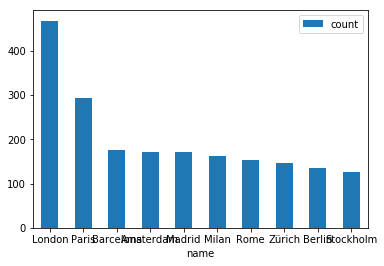

In [14]:
ax = df_master_merged.head(10).plot.bar(x='name', rot=0,)

## 3. Enriching the cities data with geonames.org lat/long 

In this section we want to take all cities information and enhance it by adding geocoordinates. These will become handy later on if we want to plot the data on a map.

We will use the free service [geonames.org](http://www.geonames.org/export/web-services.html) for this. PS you must create a free account/username in order to use it (see also http://www.geonames.org/export/credits.html). 

Geonames information will also let us do more data clean up: due to co-author information, the cities list we currenlty have contains some non-EU places 
    (e.g. New York, because authors from NY happened to be co-authoring papers with EU authors). 
These values can be easily filtered out once we the cities information from Dimensions is enriched with country codes (from geonames.org). 

First let's read the CSV created in the previous section and generate a pandas dataframe from it.

In [15]:
df1 = pd.read_csv("tmp/merged_cities_data_2019-04-23.csv")
df1.head()

,Unnamed: 0,id,name,count
0,0,2643743,London,468
1,1,2988507,Paris,293
2,2,3128760,Barcelona,176
3,3,2759794,Amsterdam,172
4,4,3117735,Madrid,171


Drop the first column and rename the second one

In [16]:
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [17]:
df1.columns = ['geonamesId', 'name', 'count']
df1.head()

,geonamesId,name,count
0,2643743,London,468
1,2988507,Paris,293
2,3128760,Barcelona,176
3,2759794,Amsterdam,172
4,3117735,Madrid,171


Now let's set up a function that queries geonames.org based on the locations IDs we have. 

PS geonames API has a hourly limit of 1000 credits/requests, hence we will slow down the execution using `time.sleep()` later on. 

In [28]:
#
geonameuser = "YOUR_USERNAME_HERE"  ############## REPLACE AS NEEDED #################
url = "http://api.geonames.org/hierarchyJSON?geonameId=%s&username=%s"
#

# eg http://api.geonames.org/hierarchyJSON?geonameId=2643743&username=mpasin
def open_geonames(_id):
    r = requests.get(url % (str(_id), geonameuser))
    return r.json()

def geonames_details(_id):
    _id = int(_id) # make sure it's a number
    data = open_geonames(_id)
    try:
        for x in data['geonames']:
            if x['geonameId'] == _id:
                lat = x['lat']
                lng = x['lng']
                countryCode = x['countryCode']
                countryName = x['countryName']
                return [lat, lng, countryCode, countryName]
    except Exception as e: 
        print(e)
        print("Error parsing JSON: %s" % str(data))
        return None
    

In [24]:
# EG
geonames_details(3522210)

['20.11697', '-98.73329', 'MX', 'Mexico']

In order to prevent losing data is the geonames API returns an error, we store the cities data a dict which we can save as JSON.  
This can be updated with geonames infos incrementally, using separate runs (if necessary). 

We use a list of dictionaries so to preserve the original order.

In [20]:
temp = {}
temp['data'] = []
for x in df1['geonamesId']:
    temp['data'].append({x: None})
with open('tmp/geonames_temp.json', 'w') as outfile:  
    json.dump(temp  , outfile)

Read the data back in for iteration

In [35]:
with open('tmp/geonames_temp.json') as infile:  
    tempfiledata = json.load(infile)

Iterate and enrich the dict with the geonames details. 

If geonames API fails, the value for a place ID remains null. 

The iteration only takes null-place info elements, so we can rerun this cell as many times as needed to get data for all places. 

In [36]:
counter = 0
for ddict in tempfiledata['data']:
    _id = next(iter(ddict)) # get first element
    if not ddict[_id]:
        print(counter, "...")
        res = geonames_details(_id)
        if res:
            tempfiledata['data'][counter][_id] = res
        time.sleep(1)
    else:
        pass 
        # print("skipping", counter)
    counter += 1

# now save to file
with open('tmp/geonames_temp.json', 'w') as outfile:  
    json.dump(tempfiledata, outfile)
print("DONE: data saved")

1435 ...
DONE: data saved


Finally, add the geonames data to the original data frame. 

We can do this by creating a list for each of the new columns, making sure they have the exact same number of elements of the original data frame.

In [37]:
lats, longs, countryCodes, countryNames = [], [], [], []
for x in tempfiledata['data']:
    _id = next(iter(x)) # get first element
    if not x[_id]:
        lats.append([""])
        longs.append([""])
        countryCodes.append([""])
        countryNames.append([""])
    else:
        lats.append(x[_id][0])
        longs.append(x[_id][1])
        countryCodes.append(x[_id][2])
        countryNames.append(x[_id][3])

len(df1) == len(lats) == len(longs) == len(countryCodes) == len(countryNames)

True

In [38]:
# when finished, update the dataframe and save 
df1['lat'] = lats
df1['lng'] = longs
df1['countryCode'] = countryCodes
df1['countryName'] = countryNames
df1.to_csv('tmp/enriched_cities_data_2019-04-23.csv')

Finally, we can remove non-EU cities from the data table

In [41]:
df1 = pd.read_csv("tmp/enriched_cities_data_2019-04-23.csv")
europe_countries = ["AD","AL","AT","AX","BA","BE","BG","BY","CH","CZ","DE","DK","EE","ES","FI","FO","FR","GB","GG","GI","GR","HR","HU","IE","IM","IS","IT","JE","LI","LT","LU","LV","MC","MD","ME","MK","MT","NL","NO","PL","PT","RO","RS","RU","SE","SI","SJ","SK","SM","UA","VA"]

to_drop = []

for x,y in enumerate(df1['countryCode']):
    if y not in europe_countries:
        to_drop += [x]
    
df1.drop(df1.index[to_drop], inplace=True)
df1.head()



,Unnamed: 0,geonamesId,name,count,lat,lng,countryCode,countryName
0,0,2643743,London,468,51.50853,-0.12574,GB,United Kingdom
1,1,2988507,Paris,293,48.85341,2.3488,FR,France
2,2,3128760,Barcelona,176,41.38879,2.15899,ES,Spain
3,3,2759794,Amsterdam,172,52.37403,4.88969,NL,Netherlands
4,4,3117735,Madrid,171,40.4165,-3.70256,ES,Spain


In [51]:
df1.describe()

,geonamesId,count
count,8.080000e+02,808.000000
mean,2.627860e+06,13.493812
std,8.137934e+05,30.379793
min,2.518330e+05,1.000000
25%,2.641306e+06,1.000000
50%,2.825690e+06,3.000000
75%,3.031248e+06,13.000000
max,6.543862e+06,468.000000


There are **808** cities from the EU listed now. 

As a final step, let's remove the first column and save the data as CSV. 

In [ ]:
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [52]:
df1.to_csv('cities_data_final_2019-04-23.csv')

That's it. This is the final dataset, which includes only EU cities infos.

## 4. Visualising the data

This final step is optional, but a bit of eye-candy will undoubtedly make you feel good :-) 

We can create a nice interactive bar chart using the open source [plotly](https://plot.ly/python/) library. 

In [46]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [47]:
plotly.__version__

'3.8.1'

In [48]:
init_notebook_mode(connected=True)

In [58]:
df = pd.read_csv("cities_data_final_2019-04-23.csv")
df.head()

,Unnamed: 0,geonamesId,name,count,lat,lng,countryCode,countryName
0,0,2643743,London,468,51.50853,-0.12574,GB,United Kingdom
1,1,2988507,Paris,293,48.85341,2.34880,FR,France
2,2,3128760,Barcelona,176,41.38879,2.15899,ES,Spain
3,3,2759794,Amsterdam,172,52.37403,4.88969,NL,Netherlands
4,4,3117735,Madrid,171,40.41650,-3.70256,ES,Spain


In [54]:
data = [go.Bar(
            x=[x for x in df['name']],
            y=[x for x in df['count']]
    )]
plot(data, filename="cities_bar.html")

'cities_bar.html'

The file `cities_bar.html` should open automatically in the browser and it'll let you dig into the data via a cool interactive bar chart! Have fun :-)

---
# Want to learn more?

Check out the [Dimensions API Lab](https://digital-science.github.io/dimensions-api-lab/) website, which contains many tutorials and reusable Jupyter notebooks for scholarly data analytics. 